In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from lib.modules import (
    read_and_window_nursing_session,
    read_nursing_session,
    read_nursing_labels,
    optimization_loop,
    evaluate_loop,
    predict_and_plot_pretty_session
)
from lib.utils import (
    plot_and_save_cm,
    plot_and_save_losses,
    summary,
    get_bouts_smoothed
)
from lib.models import ConvAutoencoder, EncoderClassifier
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset

In [3]:
raw_dir = Path("/home/musa/datasets/nursingv1")
label_dir = Path("/home/musa/datasets/eating_labels")
WINSIZE = 101
DEVICE = 'cuda:0'

In [4]:
train_sessions = [25, 67, 42, 50, 22, 61, 33, 21, 16, 18]
test_sessions = [58, 62]

Xs = []
ys = []

for session_idx in train_sessions:
    X,y = read_and_window_nursing_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xtr = torch.cat(Xs)
ytr = torch.cat(ys)

Xs = []
ys = []

for session_idx in test_sessions:
    X,y = read_and_window_nursing_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xte = torch.cat(Xs)
yte = torch.cat(ys)

In [5]:
trainloader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
testloader = DataLoader(TensorDataset(Xte,yte), batch_size=64)

In [6]:
ae_model = ConvAutoencoder(winsize=WINSIZE)
ae_model.load_state_dict(torch.load('dev/autoencoder2/best_model-39.pt'))
model = EncoderClassifier(ae_model).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
optimization_loop(model, trainloader, testloader, criterion, optimizer, 10, DEVICE, Path('dev/encoderclass2'))

In [7]:
model.load_state_dict(torch.load('dev/encoderclass2/best_model.pt'))

<All keys matched successfully>

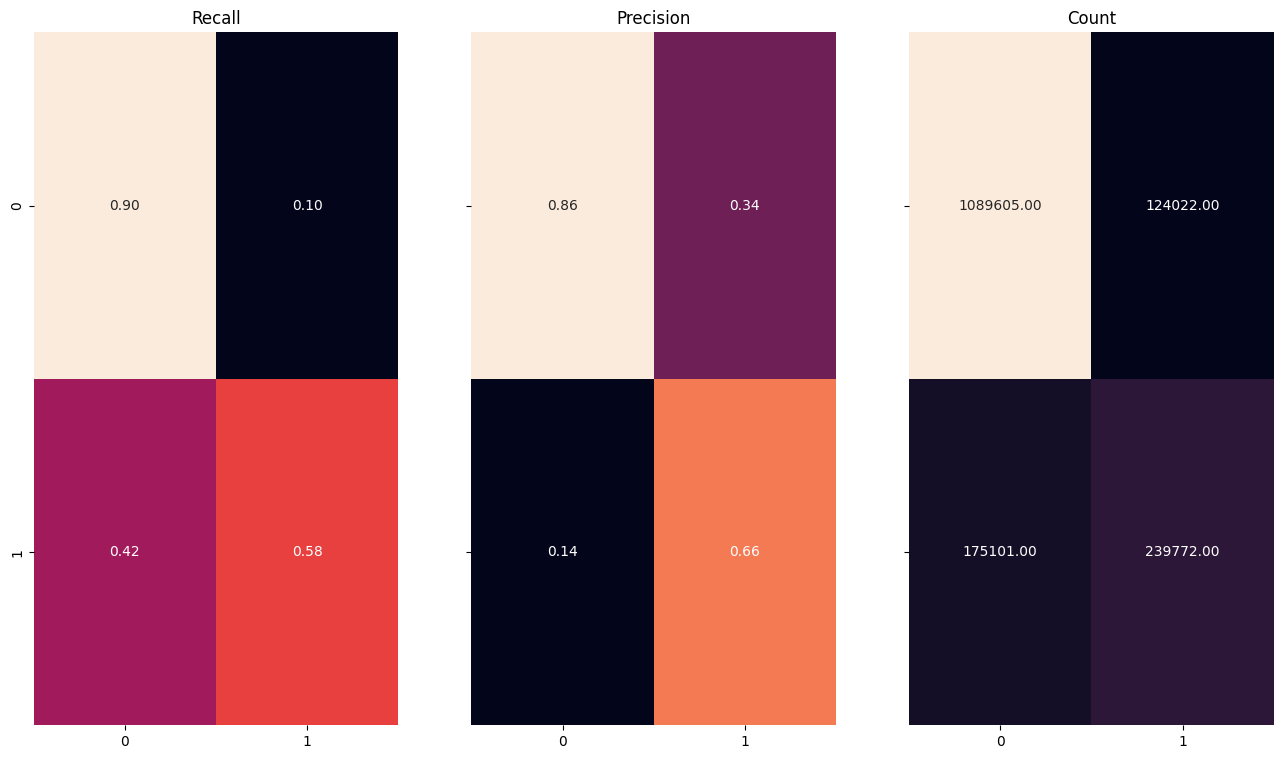

Metric        Value
---------  --------
loss       0.401765
precision  0.659087
recall     0.577941
f1         0.615852


In [20]:
ys,metrics = evaluate_loop(model, criterion, trainloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

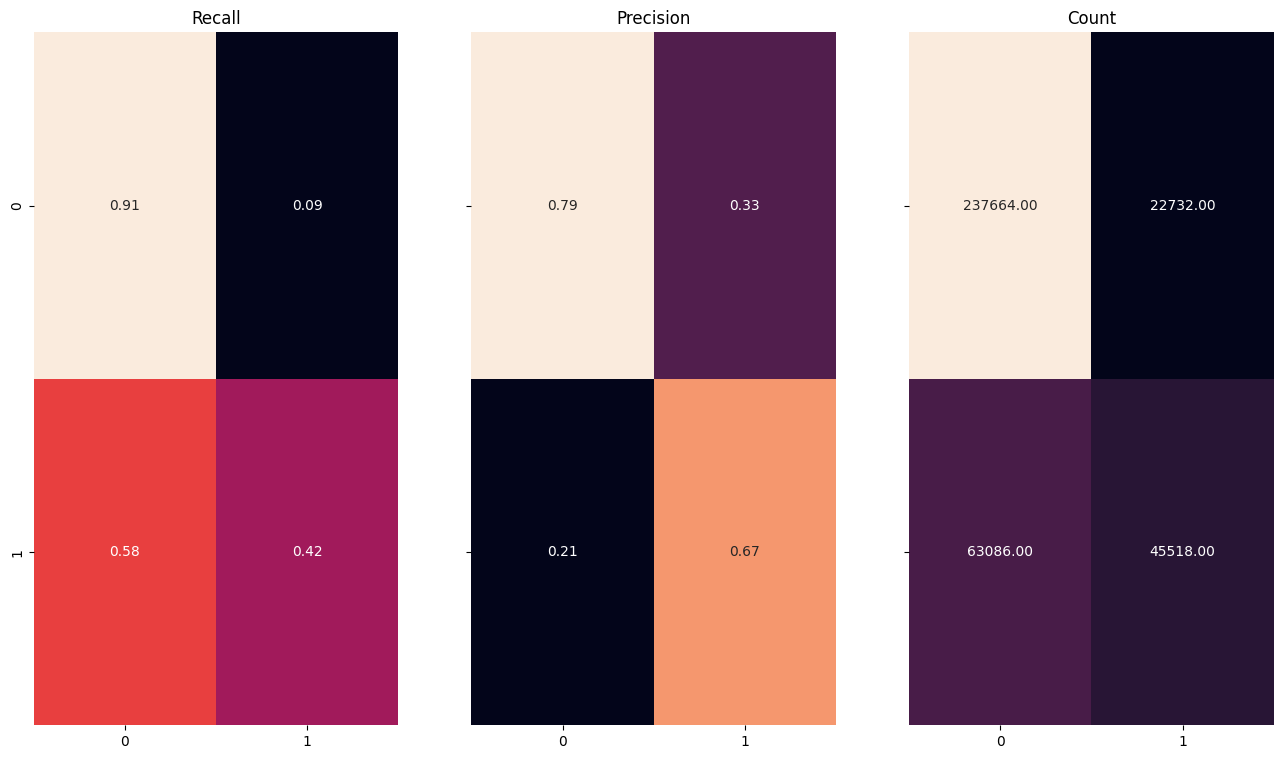

Metric        Value
---------  --------
loss       0.476266
precision  0.66693
recall     0.419119
f1         0.514752


In [22]:
ys,metrics = evaluate_loop(model, criterion, testloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

In [10]:
test_session = test_sessions[0]

predict_and_plot_pretty_session(
    session_idx=test_session,
    dim_factor=5,
    datapath=raw_dir,
    labelpath=label_dir,
    winsize=WINSIZE,
    model=model,
    criterion=criterion,
    batch_size=64,
    device=DEVICE,
    smooth=True
)

Metric        Value
---------  --------
loss       0.353616
precision  0.684396
recall     0.422769
f1         0.522671
